In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from brush import BrushGauss
import numpy as np
from lmfit import Parameters, printfuncs
from refnx.analysis import Transform, CurveFitter
from refnx.dataset import ReflectDataset
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# # load the dataset
# Q, R, dR, dQ = np.loadtxt('100mMSCN20.txt', unpack=True)
# data = tuple((Q.tolist(), R.tolist(), dR.tolist(), dQ.tolist()))
# #NB d = ReflectDataset('example.txt') work if reduction done in refnx
# d = ReflectDataset(data)
d = ReflectDataset('c_PLP0026077.dat')

In [4]:
t = Transform('logY').transform

In [5]:
# Transform the data to log R
d.y, d.y_err = t(d.x, d.y, d.y_err)

In [6]:
#Initialise BushGauss Class
a = BrushGauss(0.96, 1, n_slices=50, dq=8.85, transform=t)

In [7]:
#List parameter names
a.parameter_names()

['scale',
 'bkg',
 'SLD_super',
 'SLD_sub',
 'thickness_SiO2',
 'SLD_SiO2',
 'roughness_SiO2',
 'roughness_backing',
 'phi_init',
 'thickness_tail',
 'roughness_tail2int',
 'thickness_1',
 'phi_1',
 'roughness_1']

In [8]:
#Set up values parameters object and fill with appropriate values
P = Parameters()

vals = [0.965, 1.55e-7, 2.07, 6.165, 16, 3.83, 3, 5, 0.228, 577.15, 6.9,
            16.99, 0.976, 2, 1]
lbs = [0.93, 1e-7, 2.06, 5.8, 5, 3, 2.9, 2, 0.006, 400,3,
            2, 0.1, 2 ]
ubs = [0.97, 1e-6, 2.08, 6.36, 25, 4, 3.6, 8, 0.5, 800,10,
            20, 1.0, 5]
varies = np.array([True] * 17, bool)
varies[[0, 2, 4, 5, 6, 7]] = False

for name, val, vary, lb, ub in zip(a.parameter_names(), vals, varies, lbs, ubs):
    P.add(name, val, vary, lb, ub)

In [9]:
#Generate slab parameters and check that appropriate number generated
slab_pars = a.to_slab(P)
assert(slab_pars[0] * 4 + 8 == np.size(slab_pars))

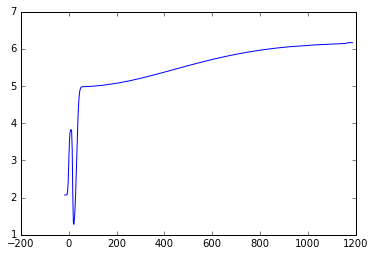

In [10]:
#Generate and plot SLD profile of initial parameters
z1, rho = a.sld_profile(P)
plt.plot(z1,rho)

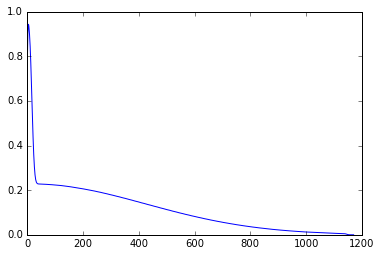

In [11]:
#Generate and plot volume fraction profile of initial parameters
z2, phi = a.vol_fraction(P)
plt.plot(z2,phi)

In [12]:
#Calculate and print area of intitial profile
area = a.vfp_area(P)
print(area)

132.127054071


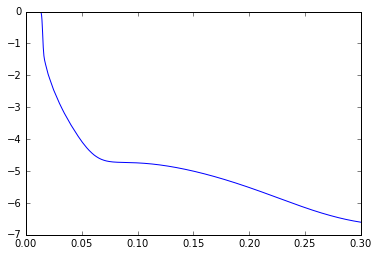

In [13]:
#Calculate and plot simulated reflectivity
q = np.linspace(0.01, 0.3, 1000)
ref = a.model(q, P)
plt.plot(q, ref)
# plt.xscale('log')

In [14]:
# Set up curve-fitting object with model, data and parameters
b = CurveFitter(a, d, P)

In [15]:
#Fit data
c = b.fit('differential_evolution',tol=0.001)

In [16]:
#Pritn Fit Report
print(printfuncs.fit_report(c))

[[Fit Statistics]]
    # function evals   = 10033
    # data points      = 121
    # variables        = 8
    chi-square         = 323.282
    reduced chi-square = 2.861
    Akaike info crit   = 143.187
    Bayesian info crit = 165.554
[[Variables]]
    scale:                0.965 (fixed)
    bkg:                  4.7488e-07 (init= 1.55e-07)
    SLD_super:            2.07 (fixed)
    SLD_sub:              6.19224793 (init= 6.165)
    thickness_SiO2:       16 (fixed)
    SLD_SiO2:             3.83 (fixed)
    roughness_SiO2:       3 (fixed)
    roughness_backing:    5 (fixed)
    phi_init:             0.23380778 (init= 0.228)
    thickness_tail:       800        (init= 577.15)
    roughness_tail2int:   4.89009133 (init= 6.9)
    thickness_1:          18.2807224 (init= 16.99)
    phi_1:                0.92524011 (init= 0.976)
    roughness_1:          5          (init= 2)
[[Correlations]] (unreported correlations are <  0.100)


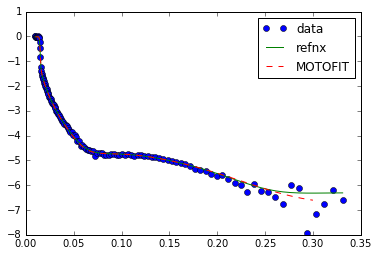

In [17]:
#Plot fit and original data
fit_ref = a.model(d.x,c.params)
plt.plot(d.x,d.y,'o',label='data')
plt.plot(d.x,fit_ref,'-',label='refnx')
plt.plot(q,ref,'--',label='MOTOFIT')
plt.legend()

In [18]:
#Check parameters
c.params

Parameters([('scale',
             <Parameter 'scale', value=0.965 (fixed), bounds=[0.93:0.97]>),
            ('bkg',
             <Parameter 'bkg', 4.7488004906108679e-07, bounds=[1e-07:1e-06]>),
            ('SLD_super',
             <Parameter 'SLD_super', value=2.07 (fixed), bounds=[2.06:2.08]>),
            ('SLD_sub',
             <Parameter 'SLD_sub', 6.1922479376428061, bounds=[5.8:6.36]>),
            ('thickness_SiO2',
             <Parameter 'thickness_SiO2', value=16 (fixed), bounds=[5:25]>),
            ('SLD_SiO2',
             <Parameter 'SLD_SiO2', value=3.83 (fixed), bounds=[3:4]>),
            ('roughness_SiO2',
             <Parameter 'roughness_SiO2', value=3 (fixed), bounds=[2.9:3.6]>),
            ('roughness_backing',
             <Parameter 'roughness_backing', value=5 (fixed), bounds=[2:8]>),
            ('phi_init',
             <Parameter 'phi_init', 0.23380778050452922, bounds=[0.006:0.5]>),
            ('thickness_tail',
             <Parameter 'thickness_t

In [19]:
#Check integrated area
a.vfp_area(c.params)

180.81518684165778

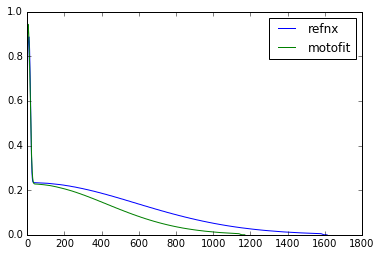

In [20]:
#Plot volume fraction profile and compare to initial parameters from MOTOFIT
z, rho = a.vol_fraction(c.params)
plt.plot(z,rho,label='refnx')
plt.plot(z2,phi,label='motofit')
plt.legend()

In [27]:
diff = CurveFitter(a, d, c.params)
e = diff.emcee(nwalkers=400, ntemps=10)

C:\Miniconda3\envs\testenv\lib\site-packages\emcee\ptsampler.py:278: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.dim))
C:\Miniconda3\envs\testenv\lib\site-packages\emcee\ptsampler.py:279: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._lnprob = np.zeros((self.ntemps, self.nwalkers, nsave))
C:\Miniconda3\envs\testenv\lib\site-packages\emcee\ptsampler.py:281: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  nsave))
C:\Miniconda3\envs\testenv\lib\site-packages\emcee\ptsampler.py:308: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  zs = np.exp(np.random.uniform(low=-np.log(self.a), high=np.log(self.a), size=(self.ntemps, self.nwalkers/2)))
C:\Miniconda3\envs\testenv\lib\site-packages\emcee\ptsampler.py:310: V

In [28]:
#Print Fit Report
print(printfuncs.fit_report(e))

[[Fit Statistics]]
    # function evals   = 0
    # data points      = unknown
    # variables        = 8
    chi-square         = unknown
    reduced chi-square = unknown
    Akaike info crit   = unknown
    Bayesian info crit = unknown
[[Variables]]
    scale:                0.965 (fixed)
    bkg:                  4.7488e-07 +/- 1.07e-08 (2.25%) (init= 4.7488e-07)
    SLD_super:            2.07 (fixed)
    SLD_sub:              6.19195149 +/- 0.005192 (0.08%) (init= 6.192248)
    thickness_SiO2:       16 (fixed)
    SLD_SiO2:             3.83 (fixed)
    roughness_SiO2:       3 (fixed)
    roughness_backing:    5 (fixed)
    phi_init:             0.23380001 +/- 0.000863 (0.37%) (init= 0.2338078)
    thickness_tail:       799.963568 +/- 7.579800 (0.95%) (init= 800)
    roughness_tail2int:   4.89023962 +/- 0.150991 (3.09%) (init= 4.890091)
    thickness_1:          18.2802938 +/- 0.129729 (0.71%) (init= 18.28072)
    phi_1:                0.92525653 +/- 0.004934 (0.53%) (init= 0.925240

In [23]:
def pgen(parameters, flatchain, idx=None):
    # generator for all the different parameters from a flatchain.
    if idx is None:
        idx = range(np.size(flatchain, 0))
    for i in idx:
        vec = flatchain.iloc[i]
        for var_name in flatchain.columns:
            parameters[var_name].value = flatchain.iloc[i][var_name]
        yield parameters

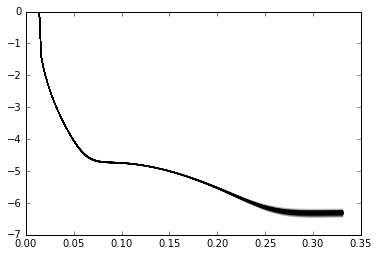

In [24]:
for pars in pgen(e.params,
                 e.flatchain,
                 idx = np.random.choice(len(e.flatchain), size=500, replace=False)):
    plt.plot(d.x,a.model(d.x,pars), color="k", alpha=0.05)


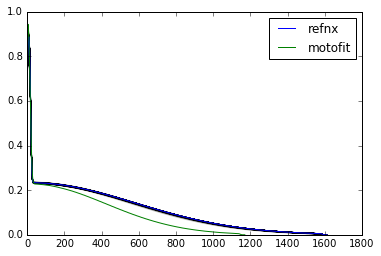

In [26]:
for pars in pgen(e.params,
                 e.flatchain,
                 idx = np.random.choice(len(e.flatchain), size=500, replace=False)):
    z, phi = a.vol_fraction(pars)
    plt.plot(z,phi, color="k", alpha=0.05)
z, rho = a.vol_fraction(c.params)
plt.plot(z,rho,label='refnx')
z2, phi = a.vol_fraction(P)
plt.plot(z2,phi,label='motofit')
plt.legend()